# Ligand-based virtual screening (QSAR):  Search for modulators for TRPM8.
 Alfonso Ortigado López

The objective of this project is to develop a Quantitative Structure-Activity Relationship (QSAR) ligand-based model using Machine Learning (ML) algorithms. The model aims to predict the IC/EC50 affinity of ligands to a target receptor. In this case, a database obtained from the ChEMBL database is used, containing molecules that have been tested for their activity on the TRPM8 channel. 

The aim of QSAR is to determine the affinity of a ligand for TRPM8, so both IC50 and EC50 values will be used. It should be noted that the IC50 is the concentration of the compound that halves the activity of a given biological target, while the EC50 is the concentration of the compound that produces a response of 50% of the maximum possible biological response. Experimental evaluation will determine the effect of the compound on TRPM8.

Relevant molecular features for the biological activity of the compounds are extracted from this database and used as inputs for the ML algorithm. The resulting model can be used to predict the biological activity of new compounds based on their chemical structure, aiding in the discovery and development of new compounds with desired biological activity (Sydow et al., 2022).

The developed QSAR programme consists of three main modules: 

- The first module, a comprehensive search of the Chembl database is carried out in order to identify compounds that interact with the target protein by means of IC50 and EC50 values. The target protein is defined using the Chembl code.

- The second module, a Machine Learning model is generated by logistic regression capable of predicting the IC/EC50 interactions based on the SMILES structures of the compounds. In this module, the program associates the SMILES structure to the IC/EC50 interaction, based on the aforementioned description.

- The third module, the generated model is applied to the prediction of compounds whose IC/EC50 value is unknown.

## 0. Packages preparation

In [1]:
# Install some packages
!pip install rdkit --quiet    
!pip install scikit-learn --quiet  
!pip install seaborn --quiet        

# Import some libreries
import requests 
import pandas as pd 
import numpy as np 
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools, MACCSkeys 
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold 
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import warnings

# Define the Base URL that links to ChEMBL
BASE_URL = "https://www.ebi.ac.uk/chembl/api/data/{:s}"

## 1. Importing the train-test data from ChEMBL

In this section, the ChEMBL code corresponding to the target protein is defined in order to obtain the compounds that interact with it through the ChEMBL web service. These data will be used to generate a predictive model of interactions based on the chemical structure of the compounds.

In [2]:
# Define the target protein 
chembl_ID = "CHEMBL1075319" # Human TRPM8

An exhaustive search of the ChEMBL database was carried out in order to identify all compounds that interact with the target protein TRPM8. For this purpose, the ChEMBL ID of the target protein in question was used. Two separate searches were performed for IC50 and EC50 interactions, as the focus is only on determining the affinity of the compounds and not on their interaction type (Leng S., 2023)(ChEMBL-Database, 2023).

In [3]:
# Get the IC50 interactions
activity_url = BASE_URL.format (f"activity?target_chembl_id__exact={chembl_ID}&offset=0&limit=0&standard_type__exact=IC50")
activity_request = requests.get(activity_url, headers={"Accept":"application/json"}).json()

df_ic50 = pd.DataFrame.from_dict(activity_request['activities'])[['molecule_chembl_id', 'type', 'standard_value', 'standard_units', "canonical_smiles"]] 
df_ic50 = df_ic50.astype({'standard_value':'float64'})
df_ic50

,molecule_chembl_id,type,standard_value,standard_units,canonical_smiles
0,CHEMBL1086310,IC50,30000.0,nM,CC(C)c1ccc(NC(=O)Cn2cnc3c2c(=O)n(C)c(=O)n3C)cc1
1,CHEMBL1173240,IC50,44000.0,nM,Cc1nc(Nc2cccc3c2C[C@H](O)CC3)oc1-c1ccc(C(F)(F)...
2,CHEMBL256087,IC50,92000.0,nM,CC1CCC(C(C)C)C(O)C1
3,CHEMBL256087,IC50,19000.0,nM,CC1CCC(C(C)C)C(O)C1
4,CHEMBL256087,IC50,520000.0,nM,CC1CCC(C(C)C)C(O)C1
...,...,...,...,...,...
621,CHEMBL3577885,IC50,13.8,nM,C[C@H](c1ccc(F)cc1)N(Cc1cccc(C(=O)O)c1)C(=O)c1...
622,CHEMBL3577885,IC50,29.6,nM,C[C@H](c1ccc(F)cc1)N(Cc1cccc(C(=O)O)c1)C(=O)c1...
623,CHEMBL4587626,IC50,10.0,µM,C[C@H](c1ccc(F)cc1)N(Cc1ccc(Cl)c(C(=O)O)c1)C(=...
624,CHEMBL5093646,IC50,4060.0,nM,CCOC(=O)c1sc(-c2cccc(F)c2)nc1C#CCCCC(=O)O


In [4]:
# Get the EC50 interactions
activity_url = BASE_URL.format (f"activity?target_chembl_id__exact={chembl_ID}&offset=0&limit=0&standard_type__exact=EC50")
activity_request = requests.get(activity_url, headers={"Accept":"application/json"}).json()

df_ec50 = pd.DataFrame.from_dict(activity_request['activities'])[['molecule_chembl_id', 'type', 'standard_value', 'standard_units', "canonical_smiles"]] 
df_ec50 = df_ec50.astype({'standard_value':'float64'})
df_ec50

,molecule_chembl_id,type,standard_value,standard_units,canonical_smiles
0,CHEMBL258405,EC50,60.00,nM,O=C1NC(c2cccc([N+](=O)[O-])c2)=CCN1c1ccccc1O
1,CHEMBL256087,EC50,29000.00,nM,CC1CCC(C(C)C)C(O)C1
2,CHEMBL256087,EC50,818000.00,nM,CC1CCC(C(C)C)C(O)C1
3,CHEMBL256087,EC50,34100.00,nM,CC1CCC(C(C)C)C(O)C1
4,CHEMBL256087,EC50,38400.00,nM,CC1CCC(C(C)C)C(O)C1
...,...,...,...,...,...
121,CHEMBL4069984,EC50,332.00,nM,C=CCc1cc(OC)c(OC(C)C(OCC)c2ccc(O)c(OC)c2)c(OC)c1
122,CHEMBL4876211,pEC50,15848.93,nM,Cn1c(Cl)cnc1CNc1ccc2sncc2c1
123,CHEMBL4849726,pEC50,15848.93,nM,Clc1cnc(CNc2ccc3sncc3c2)s1
124,CHEMBL4854482,pEC50,15848.93,nM,Clc1cnc(CNc2ccc3cnsc3c2)s1


After retrieving the data from the ChEMBL database, it has been identified that the reported interactions are in different units of measurement. Therefore, a conversion to the standard unit of measurement, that is, nanoMolar, is performed.

In [5]:
# Units Changeover: from µM to nM
for i in range(len(df_ic50)):
  if df_ic50.loc[i,'standard_units'] == 'µM':
    df_ic50.at[i,'standard_value'] *=   1000  
    df_ic50.at[i,'standard_units'] = 'nM'   
    print(f"Compound {df_ic50.loc[i,'molecule_chembl_id']} was changed" ) 


for i in range(len(df_ec50)):
  if df_ec50.loc[i,'standard_units'] == 'µM':
    df_ec50.at[i,'standard_value'] *=   1000
    df_ec50.at[i,'standard_units'] = 'nM'
    print(f"Compound {df_ec50.loc[i,'molecule_chembl_id']} was changed" ) 
    
 # Filter columns only having IC50 type and Order by IC50 value
df_ic50 = df_ic50[df_ic50['type']=='IC50'].reset_index(drop = True)
df_ec50 = df_ec50[df_ec50['type']=='EC50'].reset_index(drop = True) 

Compound CHEMBL4587626 was changed


Next, a logarithmic transformation of the IC50 and EC50 values to pIC50 and pEC50, respectively, is performed. The purpose of this transformation is to normalise the data and avoid errors in the machine learning algorithms, as some models require the data to be normally distributed or close to a normal distribution.

In [6]:
# Transform all to pXC50
for i in range(len(df_ic50)):
  if df_ic50.loc[i,'type'] == 'IC50':
    df_ic50.at[i,'standard_value'] = 9 - math.log10(df_ic50.at[i,'standard_value'])
    df_ic50.at[i,'type'] = 'pIC50'

for i in range(len(df_ec50)):
  if df_ec50.loc[i,'type'] == 'EC50':
    df_ec50.at[i,'standard_value'] = 9 - math.log10(df_ec50.at[i,'standard_value'])
    df_ec50.at[i,'type'] = 'pEC50'

Finally, the two searches, IC50 and EC50, are merged into a single table that will serve as input for the creation of the Machine Learning model.

In [7]:
df = pd.concat([df_ic50, df_ec50])
df.rename(columns={'molecule_chembl_id': 'ChEMBLID','standard_value': 'pIC50', 'standard_units': 'units', 'canonical_smiles': 'smiles'}, inplace=True )
df = df.dropna()
df = df.drop_duplicates()
df = df.sort_values(['pIC50'], ascending = [True]).reset_index(drop = True) 
df

,ChEMBLID,type,pIC50,units,smiles
0,CHEMBL25719,pEC50,2.229148,nM,CC(C)=CCC/C(C)=C/CO
1,CHEMBL256087,pEC50,3.087247,nM,CC1CCC(C(C)C)C(O)C1
2,CHEMBL256087,pIC50,3.283997,nM,CC1CCC(C(C)C)C(O)C1
3,CHEMBL3952818,pIC50,4.000000,nM,COc1cccc(CN(C(=O)c2ccccc2)[C@H](C)C(N)=O)c1
4,CHEMBL3936873,pIC50,4.000000,nM,COc1cc(CN(C(=O)c2cccs2)[C@@H](C(N)=O)c2ccccc2)...
...,...,...,...,...,...
697,CHEMBL4075397,pEC50,9.522879,nM,Cc1ccc(OCC(=O)N(Cc2cccs2)c2c(C)n[nH]c2C)cc1
698,CHEMBL4087522,pEC50,9.698970,nM,Cc1ccc(OCC(=O)N(Cc2cccs2)c2ccn[nH]2)cc1
699,CHEMBL4070838,pEC50,11.397940,nM,Cc1ccc(/C=C/C(=O)N(Cc2cccs2)c2ccn[nH]2)cc1
700,CHEMBL4069241,pEC50,11.698970,nM,O=C(/C=C/c1ccc2c(c1)OCO2)N(Cc1cccs1)c1ccn[nH]1


In [8]:
# Check the contents of the table
print(f'Standar units: {df.units.unique()}')
print(f'Standar value: {df.type.unique()}')

Standar units: ['nM']
Standar value: ['pEC50' 'pIC50']


## 2. Build the model

The Smiles molecular structure code is converted into a binary fingerprint code, which is used as input for the Machine Learning model. The conversion is carried out using a function described in TeachOpenCADD forum (Atta A., 2023)(Sydow et al., 2022).

In [9]:
def smiles_to_fp(smiles):

    mol = Chem.MolFromSmiles(smiles) 
    return np.array(MACCSkeys.GenMACCSKeys(mol))

SMILES to fingerprints conversion is performed, by default it is encoded in MACCS keys with 166 bits.

In [10]:
df["fingerprints"] = df["smiles"].apply(smiles_to_fp)
df

,ChEMBLID,type,pIC50,units,smiles,fingerprints
0,CHEMBL25719,pEC50,2.229148,nM,CC(C)=CCC/C(C)=C/CO,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL256087,pEC50,3.087247,nM,CC1CCC(C(C)C)C(O)C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL256087,pIC50,3.283997,nM,CC1CCC(C(C)C)C(O)C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL3952818,pIC50,4.000000,nM,COc1cccc(CN(C(=O)c2ccccc2)[C@H](C)C(N)=O)c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL3936873,pIC50,4.000000,nM,COc1cc(CN(C(=O)c2cccs2)[C@@H](C(N)=O)c2ccccc2)...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
697,CHEMBL4075397,pEC50,9.522879,nM,Cc1ccc(OCC(=O)N(Cc2cccs2)c2c(C)n[nH]c2C)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
698,CHEMBL4087522,pEC50,9.698970,nM,Cc1ccc(OCC(=O)N(Cc2cccs2)c2ccn[nH]2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
699,CHEMBL4070838,pEC50,11.397940,nM,Cc1ccc(/C=C/C(=O)N(Cc2cccs2)c2ccn[nH]2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
700,CHEMBL4069241,pEC50,11.698970,nM,O=C(/C=C/c1ccc2c(c1)OCO2)N(Cc1cccs1)c1ccn[nH]1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In Machine Learning, the variable X represents the features or attributes used as input for the model, while the variable Y corresponds to the output variable that is to be predicted from the input features. In this case, the variable X refers to the set of molecular characteristics of the compounds, represented by the fingerprint codes, while the variable Y corresponds to the pIC/pEC50 affinity values associated with each compound in the database.

The relationship between X and Y is used to train the Machine Learning model so that, once trained, it can predict the affinity values of new compounds based on their molecular feature set represented by the fingerprint code.

Next, the X and Y variables are defined, which will be used to generate the Machine Learning model. Variable X corresponds to the set of fingerprint code data obtained from the compounds, while variable Y represents the pIC/pEC50 values associated with each compound.

In [11]:
# Create a list of fingerprint bits and transform it into a new dataframe
df_list = df['fingerprints'].to_numpy().tolist()
fingerprintdf=pd.DataFrame(df_list)
fingerprintdf

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
698,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
699,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
700,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0


In [12]:
Finaldata = pd.concat([fingerprintdf,df["pIC50"]], axis= 1)
Finaldata

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,pIC50
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,2.229148
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,3.087247
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,3.283997
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,4.000000
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,9.522879
698,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,9.698970
699,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,11.397940
700,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,11.698970


In [13]:
# Define Y variable
Y = Finaldata.pIC50
Y

0       2.229148
1       3.087247
2       3.283997
3       4.000000
4       4.000000
         ...    
697     9.522879
698     9.698970
699    11.397940
700    11.698970
701    12.000000
Name: pIC50, Length: 702, dtype: float64

In [14]:
# Define X variable
X=Finaldata.drop(['pIC50'], axis=1)
X

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
698,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
699,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
700,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0


In the training process of the Machine Learning model, it is necessary to separate the input data X and the output data Y into training sets (train) and test sets (test) in order to evaluate the predictive capability of the model.

Therefore, the variable X and Y are divided into four subsets: X_train, Y_train, X_test and Y_test. The X_train and Y_train sets are used to train the model, while the X_test and Y_test sets are used to evaluate the predictive ability of the model.

The splitting of the data is performed randomly, ensuring that the distribution of the data is as homogeneous as possible in both sets, to avoid problems of over-fitting or under-fitting of the model. The 80% of the data is for training the model and the 20% is for testing it.

In [15]:
# Data split (80/20 ratio)
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.2 # The 20% of the data is used por testing 
                                                    ) # Split arrays or matrices into random train and test subsets.

In [16]:
# Know the data distribution
print(f'Data used for the prediction: {X.shape[0]} observations and {X.shape[1]} variables')
print(f'Data that will be redicted: {Y.shape[0]} observations')
print('-------------------------------')
print(f'Training data: {X_train.shape[0]} observations and {X_train.shape[1]} variables')
print(f'Testing data: {X_test.shape[0]} observations and {X_test.shape[1]} variables')

Data used for the prediction: 702 observations and 167 variables
Data that will be redicted: 702 observations
-------------------------------
Training data: 561 observations and 167 variables
Testing data: 141 observations and 167 variables


In this study, a fingerprint-based prediction of IC/EC50 has been carried out using Random Forest Regression. This Machine Learning model is based on combined decision trees to make accurate predictions. The process of constructing the decision trees is performed using random subsets of input variables, which allows handling data sets with high dimensionality and complex characteristics. Subsequently, the predictions of all trees are combined to obtain a final prediction (Shalev-Shwartz, S. et al., 2014).  

The follow code is used to build a regression model using the Random Forest algorithm. A set of parameters is defined for the algorithm to be evaluated using cross-validation. The parameters include the number of trees in the forest, the maximum number of features to consider at each node split, the maximum depth of each tree, the minimum number of samples required to split a node and the minimum number of samples required at each leaf of the tree. The sample selection method for training each tree is also specified, which can be with or without replacement (Fabian-Pedregosa, 2011).

Then, a grid search (GridSearchCV) is created using the Random Forest algorithm and the previously defined parameters. The model is trained with the training data (X_train and Y_train) and the best model found using the grid search is fitted. The best model found is then applied to the test data (X_test) to make a prediction (Y_pred)(Fabian-Pedregosa, 2011).

In [17]:
warnings.simplefilter('ignore') 
# Building a Regression Model using Random Forest

# Define parameters of the Random Forest to be checked with cross-validation
param_grid = {"n_estimators": [110, 150, 200],               # Number of trees in the foreset
              'max_features' : ['sqrt', 'log2'],             # Number of features to consider at every split
              "max_depth": [110, 150, 200],                  # Max number of levels in each decision tree
              'min_samples_split': [2, 4],                   # Min number of data points placed in a node before. Minimum must be 2
              'min_samples_leaf': [1, 2],                    # Min number of data points allowed in a leaf node. Minimunm must be 1
              "bootstrap": [False, True],                    # Method of selecting samples for training each tree   
              }

# Create a gridsearch using the Random Forest
clf = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='accuracy')

# Train the models using training dataset
clf.fit(X_train , Y_train)

#model = RandomForestRegressor(n_estimators=100)
model = clf.best_estimator_
print(model)

# Apply the best random forest model
randomforest = model

# Fit the model with data
randomforest.fit(X_train, Y_train)

# Perfom a prediction using XTest data
Y_pred = randomforest.predict(X_test)

RandomForestRegressor(bootstrap=False, max_depth=110, max_features='sqrt',
                      n_estimators=110)


In [18]:
# Check the difference between the actual and the predicted values
df_actual_vs_pred = pd.DataFrame({'Actual':Y_test, 'Predicted':Y_pred})
df_actual_vs_pred

,Actual,Predicted
650,8.481486,8.429283
463,7.283997,7.853872
75,5.000000,6.259081
554,7.823909,6.428906
113,5.000000,5.000000
...,...,...
411,7.040959,8.174319
423,7.091515,7.958607
126,5.000000,5.000000
589,8.022276,7.337345


In order to visualise the accuracy of the prediction model, the experimental values are plotted on the x-axis and the predicted values on the y-axis. It is important to note that the more accurate the model, the greater the tendency of the data to be close to the 1:1 line (Atta A., 2023).

<function matplotlib.pyplot.show(close=None, block=None)>

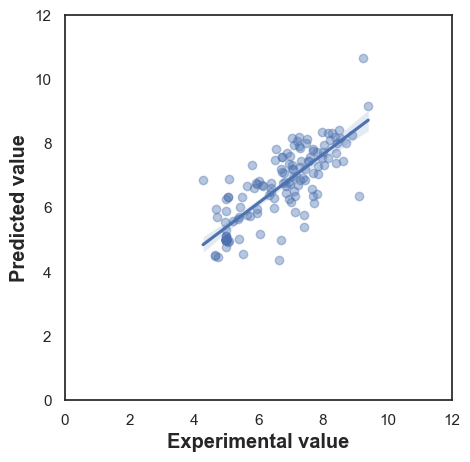

In [19]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=Y_test,y=Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental value', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted value', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

The accuracy of a logistic regression model is assessed by different metrics, such as MAE (Mean Absolute Error), MSE (Mean Squared Error) and RMAE (Root Mean Absolute Error):

- MAE: is the mean absolute value of the differences between model predictions and actual values. 
- MSE: is the mean of the square of the differences between model predictions and actual values.
- RMAE: is the square root of the MAE.

These metrics allow the performance of the logistic regression model to be evaluated in terms of the accuracy of the predictions. A low value in MAE, MSE and RMAE indicates a good accuracy of the model (Patil P. et al.,2019).


The final accuracy is calculated by calculating the mean absolute percentage error (MAPE) and is shown by subtracting the accuracy value from 100%. The MAPE is calculated as the mean absolute error (MAE) of the predictions divided by the actual value multiplied by 100%. It is used to measure the performance of forecasting models, especially in the case of time series. Accuracy is then calculated by subtracting the mean MAPE from 100% (Panchal P, et al., 2020).

In [20]:
# Evaluate the model
print('Mean Absolute Error (MAE):       ', round(metrics.mean_absolute_error(Y_test, Y_pred),2))
print('Mean Squared Error (MSE):        ', round(metrics.mean_squared_error(Y_test, Y_pred),2))
print('Root Mean Absolute Error (RMAE): ', round(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)),2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (metrics.mean_absolute_error(Y_test, Y_pred) / Y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:                        ', round(accuracy, 2), '%.')

Mean Absolute Error (MAE):        0.54
Mean Squared Error (MSE):         0.59
Root Mean Absolute Error (RMAE):  0.77
Accuracy:                         91.45 %.


## 3. Data prediction

The database that will be used to predict IC/EC50 interactions is defined. This database must contain the SMILES of the compounds to be predicted. 

In [21]:
# Define the data base
Database = pd.read_csv('Compounds.csv',  # Path where the file is 
                       delimiter=';', 
                       header= 0 )                         
Database

,Compound,Smile,InteractionType,ExperimentalValue,Units
0,Q1,[H][C@]12[C@]([C@@H](C3=CC(OCO4)=C4C=C3)OC2)([...,EC50,9800.0,nM
1,Q2,O=C1C2=C(O)C(OC)=C(O)C=C2OC(C3=CC=CC=C3)=C1,EC50,9700.0,nM
2,Q3,FC1=C(C2=NNC(C3=CC=C(F)C=C3)=C2)C(C(NC(C(F)(F)...,IC50,25.0,nM
3,Q4,O=C(N)[C@@H](C1=CC=CC=C1)N(C(C2=C(C)N=CC=C2)=O...,IC50,210.0,nM
4,Q5,C12=CC=CC=C1C(CCN(CC3=CC=CC=C3)CC4=CC=CC=C4)=CN2,IC50,3200.0,nM
5,Q6,O=C1N(CC2=CC=C(F)C=C2)C(N([C@H]1C3)[C@H](C4=CC...,IC50,60.0,nM
6,Q7,O=C(CN)N[C@@H](C1=CC=CC=C1)CNC(C2=CC(C)=CC=C2C...,IC50,210.0,nM
7,Q8,COC(C=C(CN(CCN)C(C1=CC=CS1)=O)C=C2)=C2OCC3=CC=...,IC50,64300.0,nM
8,Q9,O=C([C@@H](N(CC1=CC=CC=C1)CC2=CC=CC=C2)CC3=CNC...,IC50,40.0,nM
9,Q10,FC1=CC=CN=C1[C@H](C2=CC=C(OC(F)(F)F)C(F)=C2)NC...,IC50,1.3,nM


In [22]:
# Remove missing and repeated values
Database = Database.drop_duplicates().dropna().reset_index(drop=True)

# Encode Smiles to fingreprints
Database["fingerprints_df"] = Database["Smile"].apply(smiles_to_fp)
Database.head(5)

,Compound,Smile,InteractionType,ExperimentalValue,Units,fingerprints_df
0,Q1,[H][C@]12[C@]([C@@H](C3=CC(OCO4)=C4C=C3)OC2)([...,EC50,9800.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Q2,O=C1C2=C(O)C(OC)=C(O)C=C2OC(C3=CC=CC=C3)=C1,EC50,9700.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Q3,FC1=C(C2=NNC(C3=CC=C(F)C=C3)=C2)C(C(NC(C(F)(F)...,IC50,25.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Q4,O=C(N)[C@@H](C1=CC=CC=C1)N(C(C2=C(C)N=CC=C2)=O...,IC50,210.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Q5,C12=CC=CC=C1C(CCN(CC3=CC=CC=C3)CC4=CC=CC=C4)=CN2,IC50,3200.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [23]:
# Separate fingerprints and use them to predict the value of interaction
Predictedfp = Database["fingerprints_df"].to_numpy().tolist()
Predictedfp = pd.DataFrame(Predictedfp)

# Perform the prediction
Prediction = model.predict(Predictedfp)
Predictiondf= pd.DataFrame(Prediction, columns=['pIC50_Prediction'])
Predictiondf.head(3)

,pIC50_Prediction
0,6.095377
1,5.617316
2,6.292108


In [24]:
# Linking the prediction to the initial data set
prediction=pd.concat([Database,Predictiondf],axis=1)
prediction.head(5)

,Compound,Smile,InteractionType,ExperimentalValue,Units,fingerprints_df,pIC50_Prediction
0,Q1,[H][C@]12[C@]([C@@H](C3=CC(OCO4)=C4C=C3)OC2)([...,EC50,9800.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.095377
1,Q2,O=C1C2=C(O)C(OC)=C(O)C=C2OC(C3=CC=CC=C3)=C1,EC50,9700.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.617316
2,Q3,FC1=C(C2=NNC(C3=CC=C(F)C=C3)=C2)C(C(NC(C(F)(F)...,IC50,25.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.292108
3,Q4,O=C(N)[C@@H](C1=CC=CC=C1)N(C(C2=C(C)N=CC=C2)=O...,IC50,210.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.677781
4,Q5,C12=CC=CC=C1C(CCN(CC3=CC=CC=C3)CC4=CC=CC=C4)=CN2,IC50,3200.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.394144


A logarithmic transformation is then performed to convert the pIC/pEC50 values to IC/EC50, respectively. This is achieved by the function "convert_pic50_to_ic50" which takes the pIC50 values as input and returns the corresponding IC50 values. The results are stored in the "IC50_prediction" column of the "prediction" dataframe.

In [25]:
def convert_pic50_to_ic50(pIC50_Prediction):
    IC50_prediction = 10**(9-(pIC50_Prediction))
    return IC50_prediction

prediction["IC50_prediction"] = prediction.apply(lambda x: convert_pic50_to_ic50(x.pIC50_Prediction), axis=1)
prediction.head(3)

,Compound,Smile,InteractionType,ExperimentalValue,Units,fingerprints_df,pIC50_Prediction,IC50_prediction
0,Q1,[H][C@]12[C@]([C@@H](C3=CC(OCO4)=C4C=C3)OC2)([...,EC50,9800.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.095377,802.828869
1,Q2,O=C1C2=C(O)C(OC)=C(O)C=C2OC(C3=CC=CC=C3)=C1,EC50,9700.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.617316,2413.702288
2,Q3,FC1=C(C2=NNC(C3=CC=C(F)C=C3)=C2)C(C(NC(C(F)(F)...,IC50,25.0,nM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.292108,510.377740


array([<Axes: title={'center': 'IC50_prediction'}>], dtype=object)

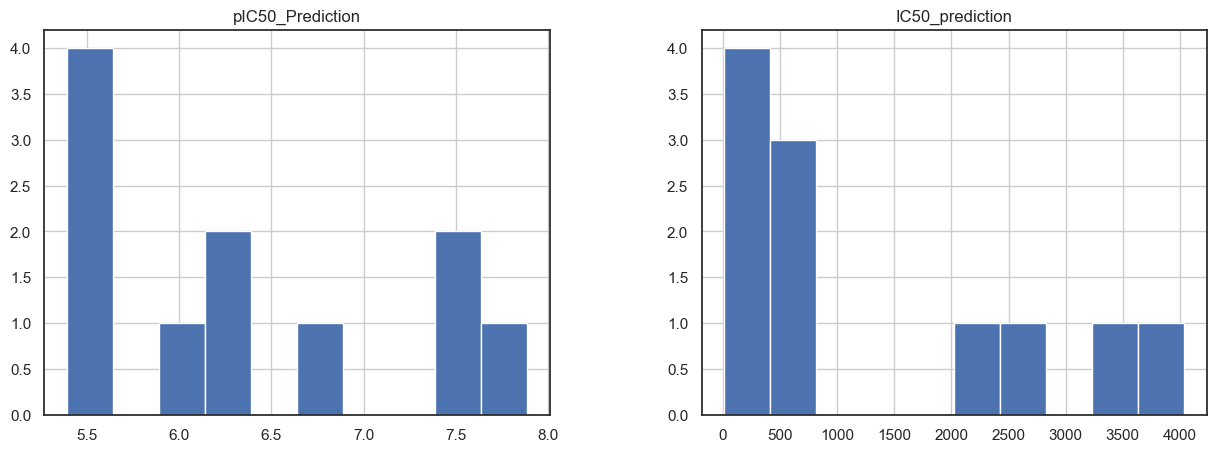

In [26]:
# The distribution of values is plotted
fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

prediction.hist(column="pIC50_Prediction", ax=axes[0])
prediction.hist(column="IC50_prediction", ax=axes[1])

In [27]:
Finalprediction = prediction.drop(['fingerprints_df'], axis=1)

if 'ExperimentalValue' in Finalprediction.columns:
    Finalprediction['pExperimentalValue'] = Finalprediction['ExperimentalValue'].apply(lambda x: 9 - math.log10(x))
    
    Y_test = np.array(Finalprediction.pExperimentalValue)
    Y_pred = np.array(Finalprediction.pIC50_Prediction)
    
    # Evaluate the prediction
    print('Mean Absolute Error:      ', round(metrics.mean_absolute_error(Y_test, Y_pred),2))
    print('Mean Squared Error:       ', round(metrics.mean_squared_error(Y_test, Y_pred),2))
    print('Root Mean Absolute Error: ', round(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)),2))

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (metrics.mean_absolute_error(Y_test, Y_pred) / Y_test)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:                 ', round(accuracy, 2), '%.')

Mean Absolute Error:       0.92
Mean Squared Error:        1.24
Root Mean Absolute Error:  1.12
Accuracy:                  84.75 %.


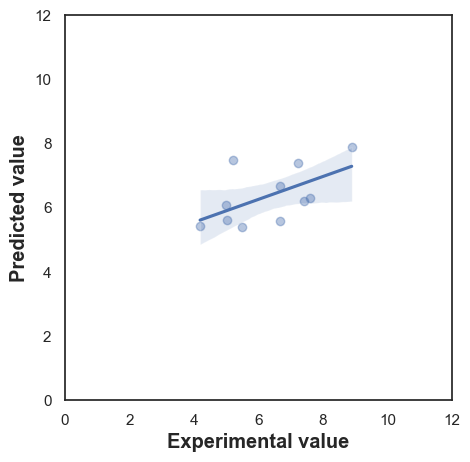

In [28]:
if 'ExperimentalValue' in Finalprediction.columns:
    sns.set(color_codes=True)
    sns.set_style("white")

    ax = sns.regplot(x=Y_test,y=Y_pred, scatter_kws={'alpha':0.4})
    ax.set_xlabel('Experimental value', fontsize='large', fontweight='bold')
    ax.set_ylabel('Predicted value', fontsize='large', fontweight='bold')
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)
    ax.figure.set_size_inches(5, 5)
    plt.show

,Compound,Smile,InteractionType,ExperimentalValue,Units,pIC50_Prediction,IC50_prediction,pExperimentalValue,ROMol
0,Q1,[H][C@]12[C@]([C@@H](C3=CC(OCO4)=C4C=C3)OC2)([...,EC50,9800.0,nM,6.095377,802.828869,5.008774,
1,Q2,O=C1C2=C(O)C(OC)=C(O)C=C2OC(C3=CC=CC=C3)=C1,EC50,9700.0,nM,5.617316,2413.702288,5.013228,
2,Q3,FC1=C(C2=NNC(C3=CC=C(F)C=C3)=C2)C(C(NC(C(F)(F)...,IC50,25.0,nM,6.292108,510.377740,7.602060,
3,Q4,O=C(N)[C@@H](C1=CC=CC=C1)N(C(C2=C(C)N=CC=C2)=O...,IC50,210.0,nM,6.677781,210.000000,6.677781,
4,Q5,C12=CC=CC=C1C(CCN(CC3=CC=CC=C3)CC4=CC=CC=C4)=CN2,IC50,3200.0,nM,5.394144,4035.119383,5.494850,
5,Q6,O=C1N(CC2=CC=C(F)C=C2)C(N([C@H]1C3)[C@H](C4=CC...,IC50,60.0,nM,7.399045,39.898330,7.221849,
6,Q7,O=C(CN)N[C@@H](C1=CC=CC=C1)CNC(C2=CC(C)=CC=C2C...,IC50,210.0,nM,5.588037,2582.041239,6.677781,
7,Q8,COC(C=C(CN(CCN)C(C1=CC=CS1)=O)C=C2)=C2OCC3=CC=...,IC50,64300.0,nM,5.440515,3626.476613,4.191789,
8,Q9,O=C([C@@H](N(CC1=CC=CC=C1)CC2=CC=CC=C2)CC3=CNC...,IC50,40.0,nM,6.199302,631.972532,7.397940,
9,Q10,FC1=CC=CN=C1[C@H](C2=CC=C(OC(F)(F)F)C(F)=C2)NC...,IC50,1.3,nM,7.886057,13.000000,8.886057,

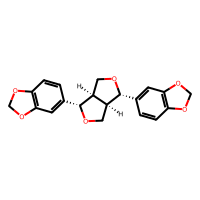
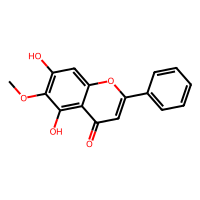
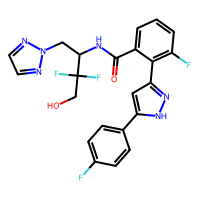
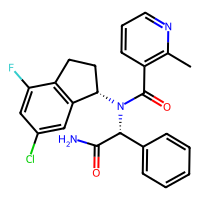
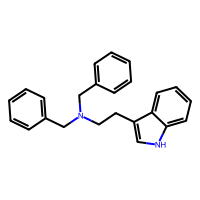
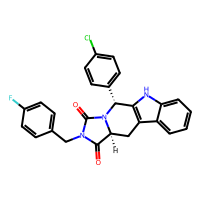
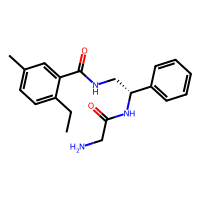
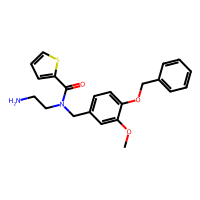
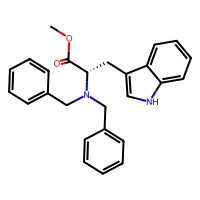
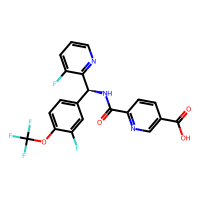
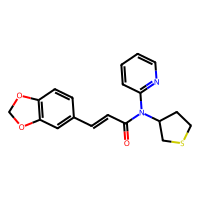

In [29]:
PandasTools.AddMoleculeColumnToFrame(Finalprediction, smilesCol='Smile')
Finalprediction

## 4. Save the prediction

In [30]:
Finalprediction.to_csv('InreactionXC50_prediction.csv', 
                       header = True, 
                       sep = ';',
                       index = False
                       )

## 5. Bibliography

•	Atta, A. (2023) T022 · Ligand-based screening: Neural Networks, TeachOpenCADD. Available at: https://projects.volkamerlab.org/teachopencadd/talktorials/T022_ligand_based_screening_neural_network.html (Accessed: April 18, 2023).

•	CHEMBL-DATABASE. 2023. ChEMBL Database (Chemical Biology Information Resource) [Online]. Available: https://www.ebi.ac.uk/chembl/ [Accessed].

•	Fabian-Pedregosa 2011. Scikit-learn: Machine Learning in Python. 85 ed. Journal of Machine Learning Research.

•	Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357-362.

•	Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95.

•	Landrum, G. (2016). RDKit: Open-source cheminformatics software. Retrieved from https://www.rdkit.org/

•	Leng, S. (2023) T001 · Compound Data Acquisition (ChEMBL), TeachOpenCADD. Available at: https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html (Accessed: April 18, 2023).

•	Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830.

•	McKinney, W. (2010). Data Structures for Statistical Computing in Python. In Proceedings of the 9th Python in Science Conference (pp. 51-56).

•	Panchal, P., Patel, P., & Upadhyay, R. (2020). Review of error metrics for evaluating performance of regression models. SN Computer Science, 1-21.

•	Patil, P., & Kulkarni, V. (2019). Performance evaluation of regression models: A review. Journal of Intelligent & Fuzzy Systems, 36(3), 2087-2096.

•	Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Vanderplas, J. (2011). 

•	Shalev-Shwartz, S., & Ben-David, S. (2014). Understanding machine learning: from theory to algorithms. Cambridge University Press.

•	SYDOW, D., RODRÍGUEZ-GUERRA, J., KIMBER, TALIA B., SCHALLER, D., TAYLOR, COREY J., CHEN, Y., LEJA, M., MISRA, S., WICHMANN, M., ARIAMAJD, A. & VOLKAMER, A. 2022. TeachOpenCADD 2022: open source and FAIR Python pipelines to assist in structural bioinformatics and cheminformatics research. Nucleic Acids Research, 50, W753-W760.

•	Waskom, M. (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021.
